In [12]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from glob import glob

from utils.plotter import Plotter
from utils.data_handler import DataHandler

labels = ["bias20_loc"]
root = lambda x, y: f"./output_{x}/work{y}/"
n_works = len(glob(root(labels[0], "*")))
template = lambda x, y: f"{root(x, y)}/output/"
data_folder = lambda x: template(labels[0], x)
noise_file = lambda x: f"{root(labels[0], x)}/airpressure_noise.nc"
folder = data_folder(0)
output_folder = "figs"

obs_file = "/home/mverlaan/einf220/fromDavid/gtsm_openDA_david/stochObserver/clipped_averaged.nc"
# obs_file = "./stochObserver/clipped_averaged.nc"

his_file = "full_gtsm_fine_0000_his.nc"
av_file = "full_gtsm_fine_averaged_0000_his.nc"
end_date = "2014-06-08"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


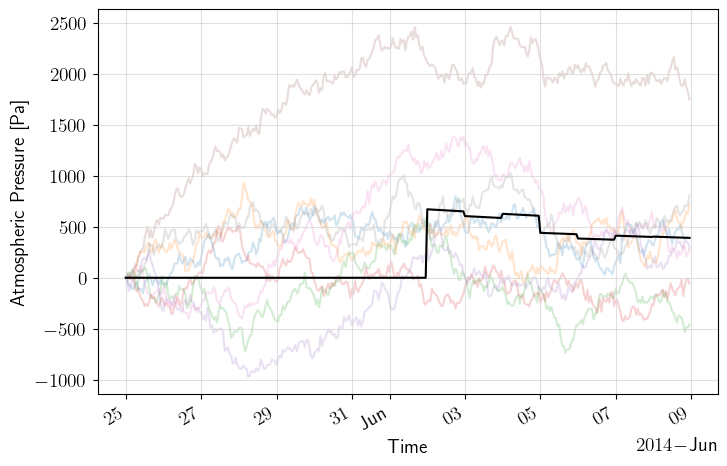

In [13]:
# x = -85.7
# y = 30.1
x = -147.5
y = -60
Plotter.__setup_config__()
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=Plotter.figsize_standard)
for i in range(n_works):
    if i == 0:
        kwargs = {"color": "k", "zorder": 3}
    else:
        kwargs = {"alpha": Plotter.ensemble_alpha, "zorder": -1}
    nc = xr.load_dataset(noise_file(i))
    nc.interp(y=y, x=x).sel(time=slice(None, end_date)).p.plot(
        ax=ax, label=f"{i}", **kwargs
    )
Plotter.grid(ax)
Plotter.date_axis(ax)
plt.xlabel(Plotter.t_label)
plt.savefig(Plotter.add_folder("noise.pdf"), bbox_inches="tight")
plt.title("")
plt.show()

<Figure size 640x480 with 0 Axes>

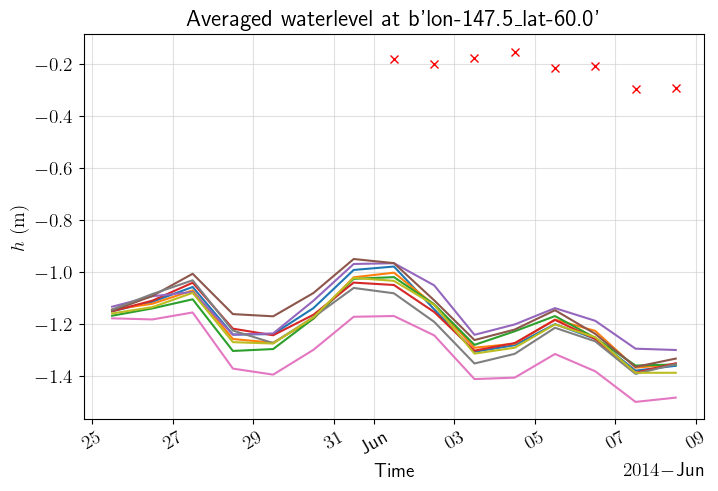

In [14]:
obs_data = xr.load_dataset(obs_file)

stations = range(2, 3)
for station in stations:
    title_func = lambda s: f"Averaged waterlevel at {s}"
    ts = []
    ws = []
    works = list(range(n_works))
    works = [str(x) for x in works]
    for work in works:
        file = os.path.join(data_folder(work), av_file)
        nc_his = xr.load_dataset(file)
        station_data = nc_his.isel(stations=station)
        ts.append(station_data.time)
        loc_name = nc_his.station_name.isel(stations=station).item()
        loc_name = loc_name.strip()
        ws.append(station_data.waterlevel)

    # Observations
    station_data = obs_data.isel(stations=station)
    observations = [station_data.time.to_numpy(), station_data.waterlevel.to_numpy()]
    Plotter.plot_series(
        ts,
        ws,
        loc_name,
        title_func,
        obs_data=observations,
    )
    plt.show()

In [4]:
from datetime import datetime, timedelta, timezone

nc = xr.load_dataset("./algorithm/kgStorage_201405270000/kalmanGainStorage.nc")

FileNotFoundError: [Errno 2] No such file or directory: b'/gpfs/scratch1/shared/mverlaan/experiment_gtsm/algorithm/kgStorage_201405270000/kalmanGainStorage.nc'

In [ ]:
from datetime import datetime, timedelta, timezone

files = glob("./algorithm/*/*.nc")
data_files = [xr.open_dataset(file) for file in files]
ncs = []
times = []
for file in files:
    nc = xr.load_dataset(file)
    time = pd.to_datetime(datetime(1858, 11, 17)) + nc.time_stamp.values[0]
    nc["time_stamp"] = time
    ncs.append(nc)
    times.append(time)

nc = xr.concat(ncs, pd.Index(times, name="time"))
nc = nc.rename_dims({"station_dimension": "stations"})
nc.isel(stations=0).s1[:, 0].plot()